作者: 阿凯爱玩机器人 | 微信: xingshunkai  | QQ: 244561792

[B站](https://space.bilibili.com/40344504) | [淘宝店铺](https://shop140985627.taobao.com) | [购买链接](https://item.taobao.com/item.htm?id=677075846402)
## 导入依赖

In [1]:
import time
import numpy as np
import cv2
# 阿凯机器人工具箱
from kyle_robot_toolbox.camera import Gemini335
from kyle_robot_toolbox.opencv import ArucoTag
from kyle_robot_toolbox.open3d import *
# ArucoTag可视化窗口
from arucotag_visualizer import ArucoTagVisualizer
# ArucoTag姿态矫正器
from arucotag_pose_adjust import *

from matplotlib import pyplot as plt

%matplotlib inline

pybullet build time: Jun  3 2022 02:05:55


## 相机初始化

In [2]:
# 创建相机对象
camera = Gemini335()

## 创建ArucoTag检测器

In [3]:
# 创建ArucoTag检测器
arucotag = ArucoTag(camera, \
	config_path="config/arucotag/arucotag.yaml")

## 图像采集

In [5]:
# 采集彩图与深度图
img_bgr, depth_img = camera.read()
# 图像移除畸变
img_bgr = camera.remove_distortion(img_bgr)
# 图像预处理
img_filter = image_preprocessor(img_bgr)
# 根据深度图生成画布
depth_canvas = camera.depth_img2canvas(depth_img, min_distance=150, max_distance=300)
# 生成场景点云
scene_pcd = camera.get_pcd(img_filter, depth_img)

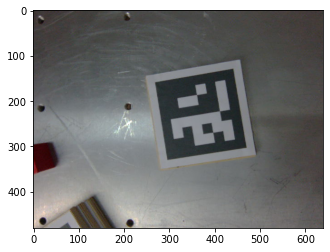

In [6]:
plt.imshow(img_bgr[:, :, ::-1])

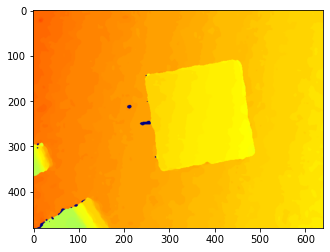

In [7]:
plt.imshow(depth_canvas[:, :, ::-1])

In [8]:
cv2.imwrite("img_bgr.png", img_bgr)
cv2.imwrite("depth_canvas.png", depth_canvas)

True

In [9]:
# ArucoTag检测
has_aruco, canvas, aruco_ids, aruco_centers,\
    aruco_corners, T_cam2aruco_by2d = \
    arucotag.aruco_pose_estimate(img_filter)

# 矫正ArucoTag的坐标
# 注: 返回的t_cam2aruco_by3d是过滤后的
valid_aruco_mask, t_cam2aruco_by3d_filter = get_t_cam2aruco_by3d(\
        camera, depth_img, aruco_ids, aruco_centers,  \
        canvas=canvas, depth_canvas=depth_canvas)
# 过滤有效的ID、中心、角点、空间变换
# 矫正ArucoTag的姿态
aruco_ids_filter = aruco_ids[valid_aruco_mask]
aruco_centers_filter = aruco_centers[valid_aruco_mask]
aruco_corners_filter = aruco_corners[valid_aruco_mask]
T_cam2aruco_by2d_filter = T_cam2aruco_by2d[valid_aruco_mask]
# 获取矫正后的ArucoTag姿态
T_cam2aruco_by3d_filter = adjust_T_cam2aruco(camera, img_filter, depth_img, \
    aruco_ids_filter, aruco_corners_filter, \
    T_cam2aruco_by2d_filter, t_cam2aruco_by3d_filter)

In [10]:
T_cam2aruco_by3d_filter

[array([[  0.986,  -0.162,  -0.049,  21.041],
        [ -0.163,  -0.987,  -0.008,  -3.244],
        [ -0.048,   0.016,  -0.999, 247.   ],
        [  0.   ,   0.   ,   0.   ,   1.   ]])]

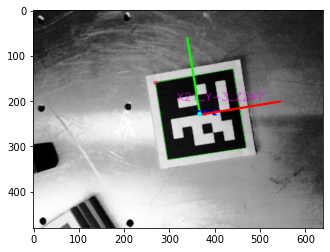

In [11]:
plt.imshow(canvas[:, :, ::-1])

In [12]:
cv2.imwrite("canvas.png", canvas)

True

## 可视化ArucoTag位姿估计结果

In [13]:
# 相机在世界坐标系下的位姿(相机外参)
T_world2cam = np.eye(4)
# 相机内参
intrinsic = camera.intrinsic_new
# 图像尺寸
img_width = camera.img_width
img_height = camera.img_height
# 可视化相机平面距离相机坐标系原点距离
# 单位m
panel_distance = 0.1
# 创建相机相关的Gemometry
camera_geometries = geometry_camera(intrinsic, T_world2cam, \
        img_width, img_height, \
        panel_distance = panel_distance, \
        color=[0.8, 0.2, 0.2], \
        draw_panel=False)

In [14]:
aruco_size = 0.08
box_depth = 0.01

aruco_geometry_list = []

for T_cam2aruco in T_cam2aruco_by3d_filter:
    # 单位mm转m
    T_cam2board_m = np.copy(T_cam2aruco)
    T_cam2board_m[:3, 3] /= 1000.0
    # ArucoTag坐标系
    coord = geometry_coordinate(T_cam2board_m, size=aruco_size*1.5)
    # ArucoTag板
    # ArucoTag尺寸
    board_width, board_height = aruco_size, aruco_size 
    board = geometry_box(T_cam2board_m, board_width, board_height,\
                        box_depth=box_depth, color=[0.0, 0.5, 0.0])
    aruco_geometry_list.append(coord)
    aruco_geometry_list.append(board)

In [15]:
draw_geometry([scene_pcd] + camera_geometries + aruco_geometry_list)